In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path().absolute().parent))


In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)

import matplotlib.pyplot as plt


import seaborn as sns

import pandas as pd
from pathlib import Path


from src.data_models.caravanify import Caravanify, CaravanifyConfig

from src.data_models.datamodule import HydroDataModule

from sklearn.pipeline import Pipeline

from src.preprocessing.grouped import GroupedTransformer
from src.preprocessing.standard_scale import StandardScaleTransformer

In [3]:
from src.models.TSMixerDomainAdaptation import LitTSMixerDomainAdaptation
from src.models.evaluators import TSForecastEvaluator

---

## Getting data for Chile

In [4]:
# Configuration for loading Central Asian (CA) hydrology data
CL_config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CL/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CL/post_processed/timeseries/csv",
    gauge_id_prefix="CL",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)

# Initialize Caravan data loader and load first 3 stations for training
CL_caravan = Caravanify(CL_config)
ids_for_training = CL_caravan.get_all_gauge_ids()[:3]
print(f"Total number of stations: {len(ids_for_training)}")
CL_caravan.load_stations(ids_for_training)

# Get time series and static data
CL_ts_data = CL_caravan.get_time_series()
CL_static_data = CL_caravan.get_static_attributes()

# Process time series data
CL_ts_data["date"] = pd.to_datetime(CL_ts_data["date"])
CL_ts_data["julian_day"] = CL_ts_data["date"].dt.dayofyear

# Select relevant time series features
ts_columns = ["streamflow", "total_precipitation_sum"]
CL_ts_data = CL_ts_data[ts_columns + ["gauge_id", "date"]]

# Select relevant static features that characterize catchment properties
static_columns = [
    "gauge_id",
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]
CL_static_data = CL_static_data[static_columns]

# Separate features from target variable
features = [
    col for col in CL_ts_data.columns if col not in ["gauge_id", "date", "streamflow"]
]
ts_columns = features + ["streamflow"]

feature_pipeline = Pipeline([("scaler", StandardScaleTransformer(columns=features))])

target_pipeline = GroupedTransformer(
    Pipeline([("scaler", StandardScaleTransformer(columns=["streamflow"]))]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

static_pipeline = Pipeline(
    [("scaler", StandardScaleTransformer(columns=static_columns[1:]))]
)

# Define preprocessing configurations
preprocessing_configs = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline},
}

Total number of stations: 3


In [5]:
batch_size = 128
output_length = 10
input_length = 64
hidden_size = 32

# # Create data module with the trial's batch size and input length
# CL_data_module = HydroDataModule(
#     time_series_df=CL_ts_data,
#     static_df=CL_static_data,
#     group_identifier="gauge_id",
#     preprocessing_config=preprocessing_configs,
#     batch_size=batch_size,  # Use trial's batch size
#     input_length=input_length,  # Use trial's input length
#     output_length=output_length,
#     num_workers=4,
#     features=ts_columns,
#     static_features=static_columns,
#     target="streamflow",
#     min_train_years=2,
#     val_years=1,
#     test_years=3,
#     max_missing_pct=10,
#     domain_id="target",
# )

# CL_data_module.prepare_data()
# CL_data_module.setup()

## Getting data for Switzerland

In [6]:
CH_config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CH/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CH/post_processed/timeseries/csv",
    gauge_id_prefix="CH",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)

# Initialize Caravan data loader and load first 3 stations for training
CH_caravan = Caravanify(CH_config)
ids_for_training = CH_caravan.get_all_gauge_ids()[:3]
print(f"Total number of stations: {len(ids_for_training)}")
CH_caravan.load_stations(ids_for_training)

# Get time series and static data
CH_ts_data = CH_caravan.get_time_series()
CH_static_data = CH_caravan.get_static_attributes()

# Process time series data
CH_ts_data["date"] = pd.to_datetime(CH_ts_data["date"])
CH_ts_data["julian_day"] = CH_ts_data["date"].dt.dayofyear

# Select relevant time series features
ts_columns = ["streamflow", "total_precipitation_sum"]
CH_ts_data = CH_ts_data[ts_columns + ["gauge_id", "date"]]

# Select relevant static features that characterize catchment properties
static_columns = [
    "gauge_id",
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]
CH_static_data = CH_static_data[static_columns]

# Separate features from target variable
features = [
    col for col in CH_ts_data.columns if col not in ["gauge_id", "date", "streamflow"]
]
ts_columns = features + ["streamflow"]

# Define preprocessing pipelines
feature_pipeline = Pipeline([("scaler", StandardScaleTransformer(columns=features))])

target_pipeline = GroupedTransformer(
    Pipeline([("scaler", StandardScaleTransformer(columns=["streamflow"]))]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

static_pipeline = Pipeline(
    [("scaler", StandardScaleTransformer(columns=static_columns[1:]))]
)

# Define preprocessing configurations
preprocessing_configs = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline},
}

Total number of stations: 3


In [7]:
# CH_data_module = HydroDataModule(
#     time_series_df=CH_ts_data,
#     static_df=CH_static_data,
#     group_identifier="gauge_id",
#     preprocessing_config=preprocessing_configs,
#     batch_size=batch_size,  # Use trial's batch size
#     input_length=input_length,  # Use trial's input length
#     output_length=output_length,
#     num_workers=4,
#     features=ts_columns,
#     static_features=static_columns,
#     target="streamflow",
#     min_train_years=2,
#     val_years=1,
#     test_years=3,
#     max_missing_pct=10,
#     domain_id="source",
# )

# CH_data_module.prepare_data()
# CH_data_module.setup()

## Testing Multi Domain Loader

In [ ]:
combined_dm = HydroDataModule(
    time_series_df=[CH_ts_data, CL_ts_data],
    static_df=[CH_static_data, CL_static_data],
    group_identifier="gauge_id",
    preprocessing_config=preprocessing_configs,
    batch_size=batch_size,  # Use trial's batch size
    input_length=input_length,  # Use trial's input length
    output_length=output_length,
    num_workers=4,
    features=ts_columns,
    static_features=static_columns,
    target="streamflow",
    min_train_years=2,
    val_years=1,
    test_years=3,
    max_missing_pct=10,
    domain_id="source",
)

combined_dm.prepare_data()
combined_dm.setup()

Original basins: 6
Retained basins: 3
Domain source (source): Created 39225 valid sequences from 3 catchments
Domain source (source): Created 876 valid sequences from 3 catchments
Domain source (source): Created 3069 valid sequences from 3 catchments


## Training the model

In [9]:
from src.models.TSMixer import LitTSMixer, TSMixerConfig
from src.models.evaluators import TSForecastEvaluator

In [10]:
config = TSMixerConfig(
    input_len=input_length,
    output_len=output_length,
    input_size=len(ts_columns),
    static_size=len(static_columns) - 1,
    hidden_size=30,
    learning_rate=7e-4,
    dropout=0.1,
    num_layers=2,
)

model = LitTSMixer(config)

# Configure trainer
trainer = pl.Trainer(
    max_epochs=4,
    accelerator="cpu",
    devices=1,
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss",
            dirpath="checkpoints",
            filename="best-checkpoint",
            save_top_k=1,
            mode="min",
        ),
        EarlyStopping(monitor="val_loss", patience=3, mode="min"),
        LearningRateMonitor(logging_interval="epoch"),
    ],
)

# Train the model
trainer.fit(model, combined_dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Original basins: 6
Retained basins: 3


/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/cooper/Desktop/CAMELS-CH/notebooks/checkpoints exists and is not empty.

  | Name          | Type    | Params | Mode 
--------------------------------------------------
0 | model         | TSMixer | 12.9 K | train
1 | mse_criterion | MSELoss | 0      | train
--------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.052     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


Domain source (source): Created 39225 valid sequences from 3 catchments
Domain source (source): Created 876 valid sequences from 3 catchments


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


In [11]:
trainer.test(model, combined_dm)
raw_results = model.test_results

# Create evaluator and get metrics
evaluator = TSForecastEvaluator(
    combined_dm, horizons=list(range(1, model.config.output_len + 1))
)
results_df, overall_metrics, basin_metrics = evaluator.evaluate(raw_results)

# Get overall summary
overall_summary = evaluator.summarize_metrics(overall_metrics)

# Get per-basin summary
basin_summary = evaluator.summarize_metrics(basin_metrics, per_basin=True)

Original basins: 6
Retained basins: 3
Domain source (source): Created 3069 valid sequences from 3 catchments


Testing: |          | 0/? [00:00<?, ?it/s]

Found 1023 matches for CH_2016
Extracted 1023 predictions and 1023 observations
Predictions range: [-1.168347716331482, 1.947219729423523]
Observations range: [-1.47349214553833, 2.3415112495422363]
After inverse transform:
Predictions range: [1.0935391187667847, 4.499018669128418]
Observations range: [0.7600001096725464, 4.930000305175781]
Found 1096 rows for basin CH_2016 in dataset
Extracted 1023 test dates
First date: 2018-03-15T00:00:00.000000000, Last date: 2020-12-31T00:00:00.000000000
Found 1023 matches for CH_2016
Extracted 1023 predictions and 1023 observations
Predictions range: [-1.1441859006881714, 1.8473010063171387]
Observations range: [-1.47349214553833, 2.3415112495422363]
After inverse transform:
Predictions range: [1.119949221611023, 4.389801979064941]
Observations range: [0.7600001096725464, 4.930000305175781]
Found 1096 rows for basin CH_2016 in dataset
Extracted 1023 test dates
First date: 2018-03-15T00:00:00.000000000, Last date: 2020-12-31T00:00:00.000000000
Fou

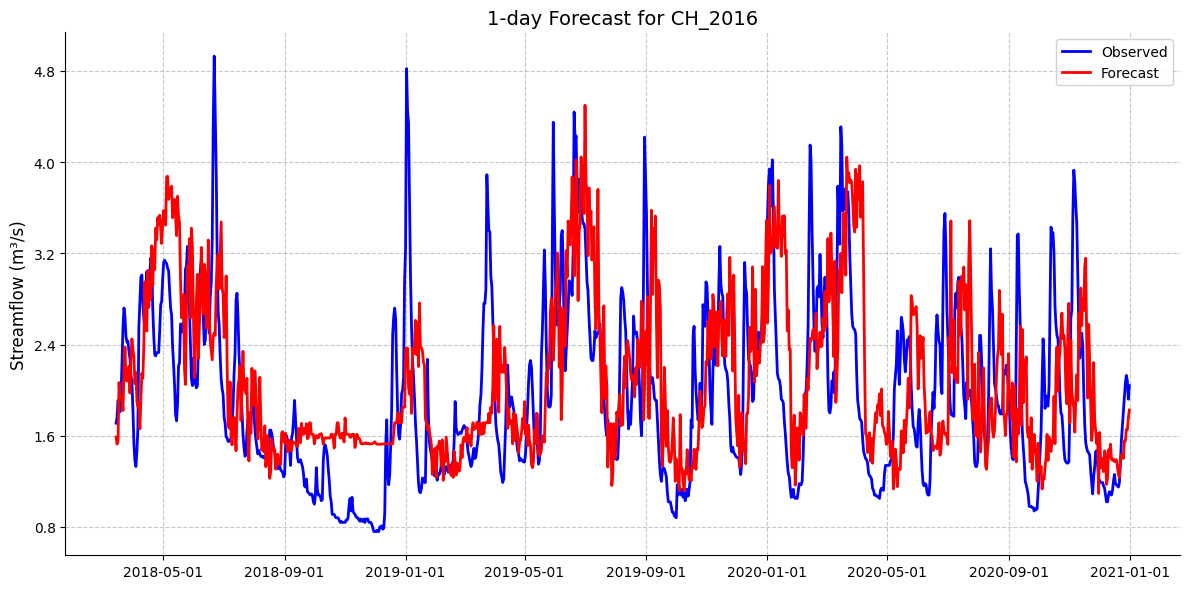

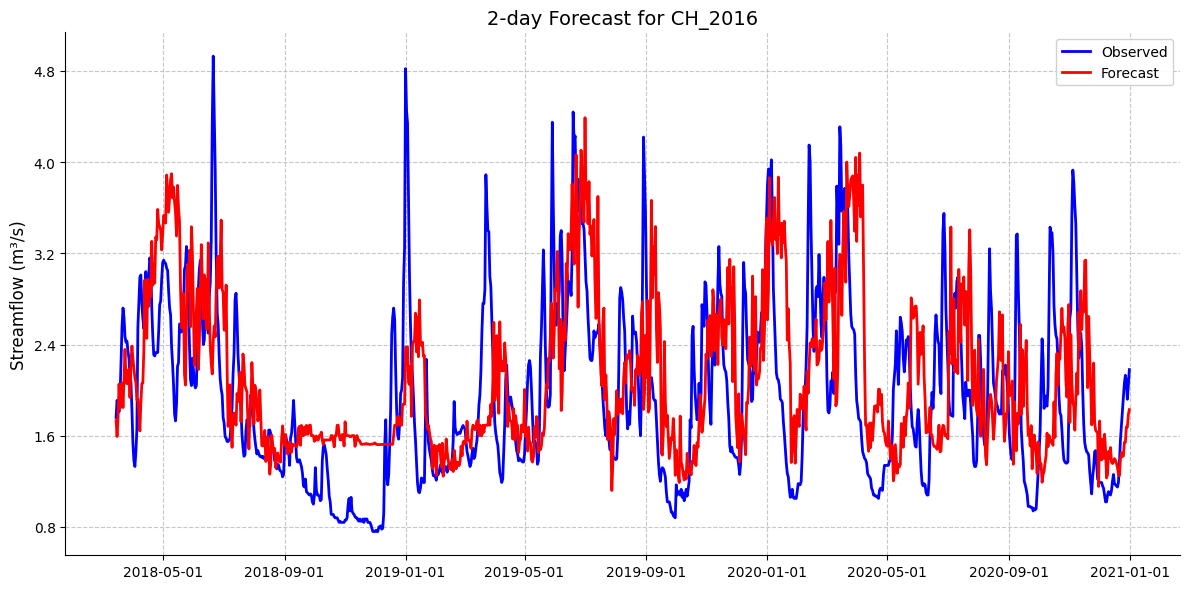

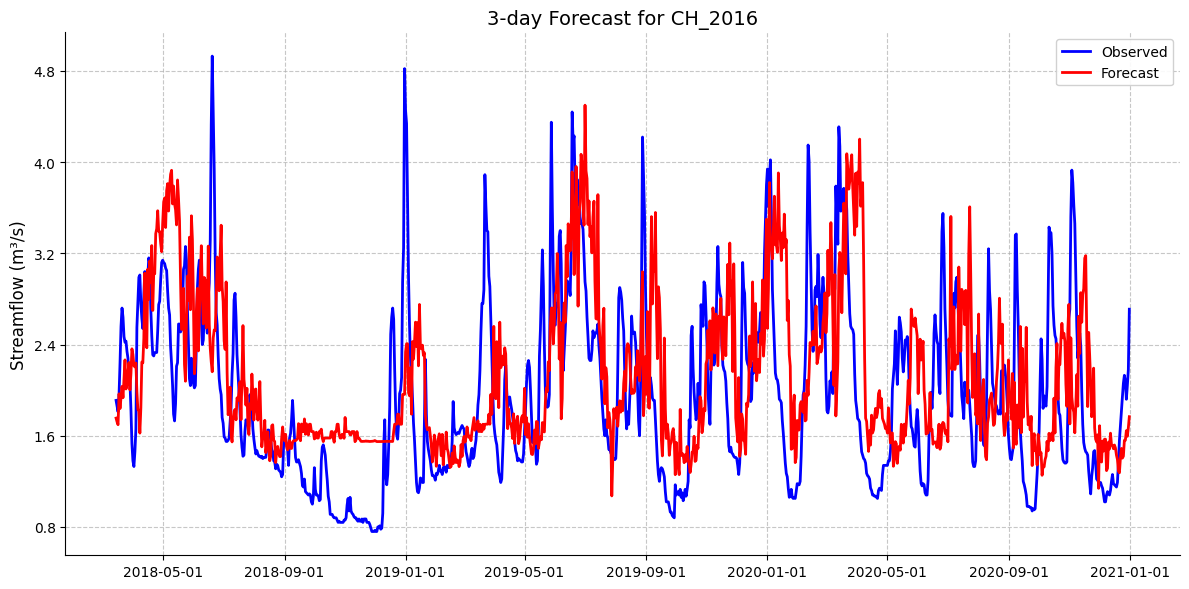

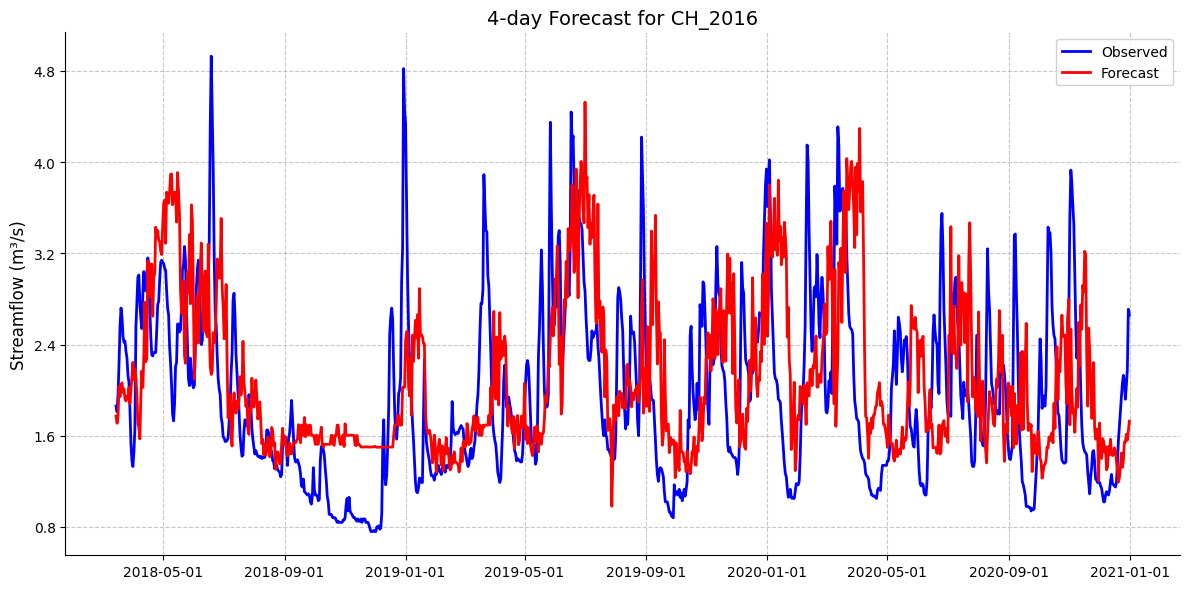

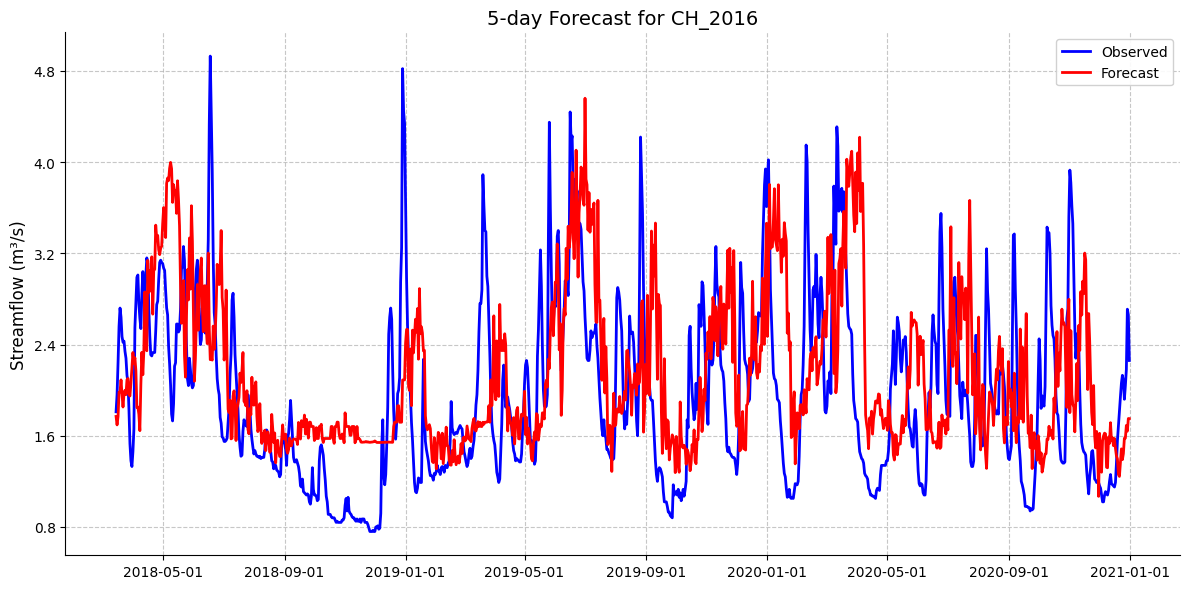

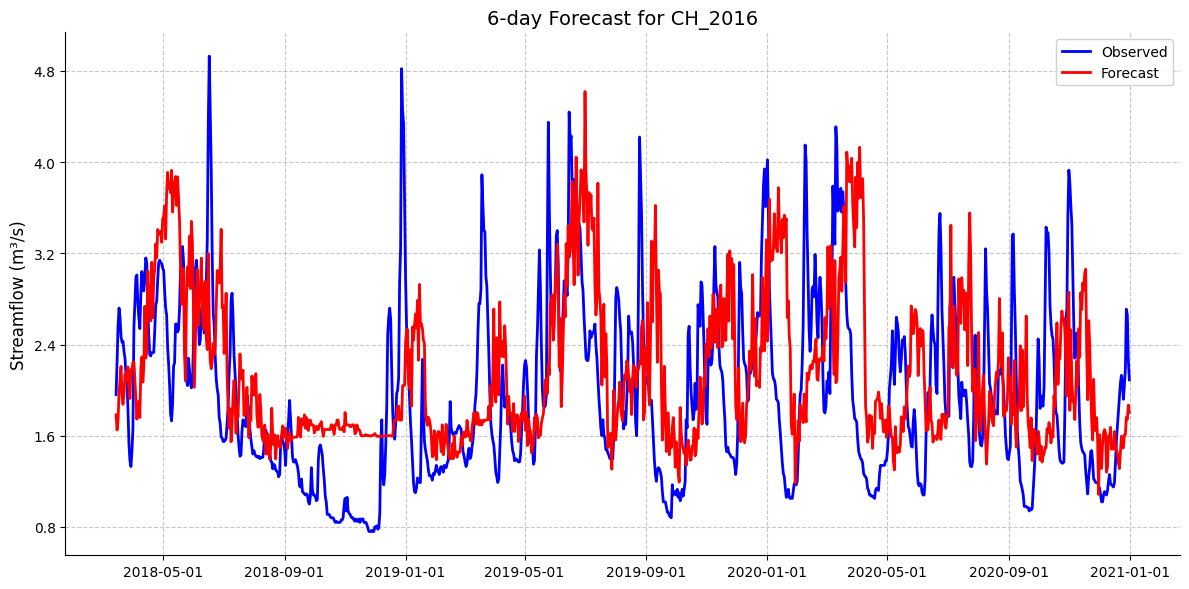

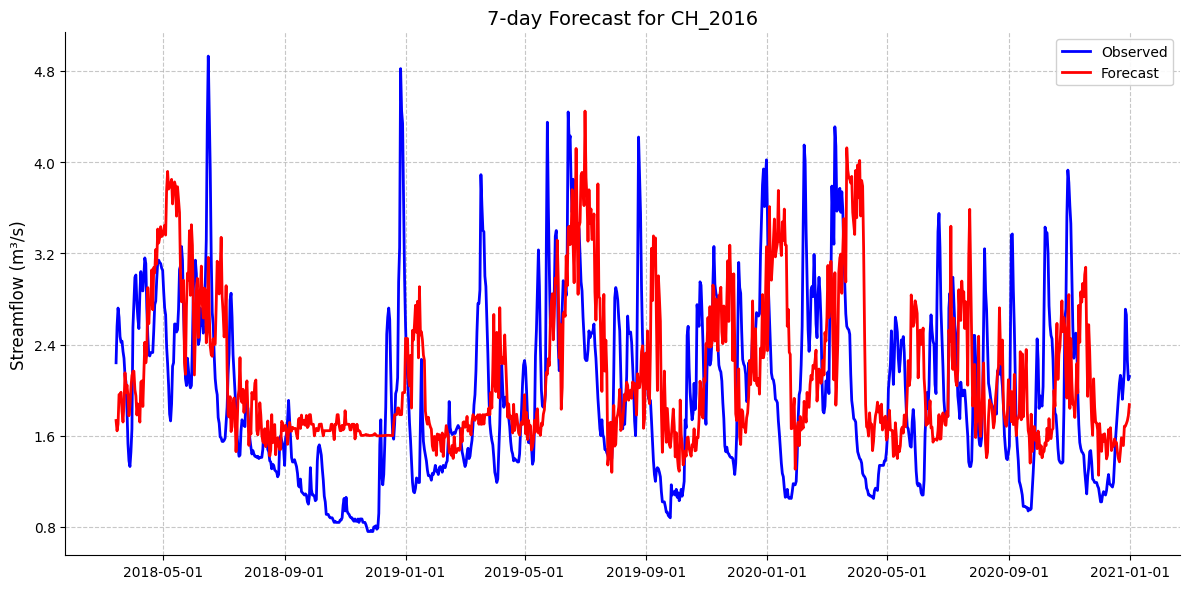

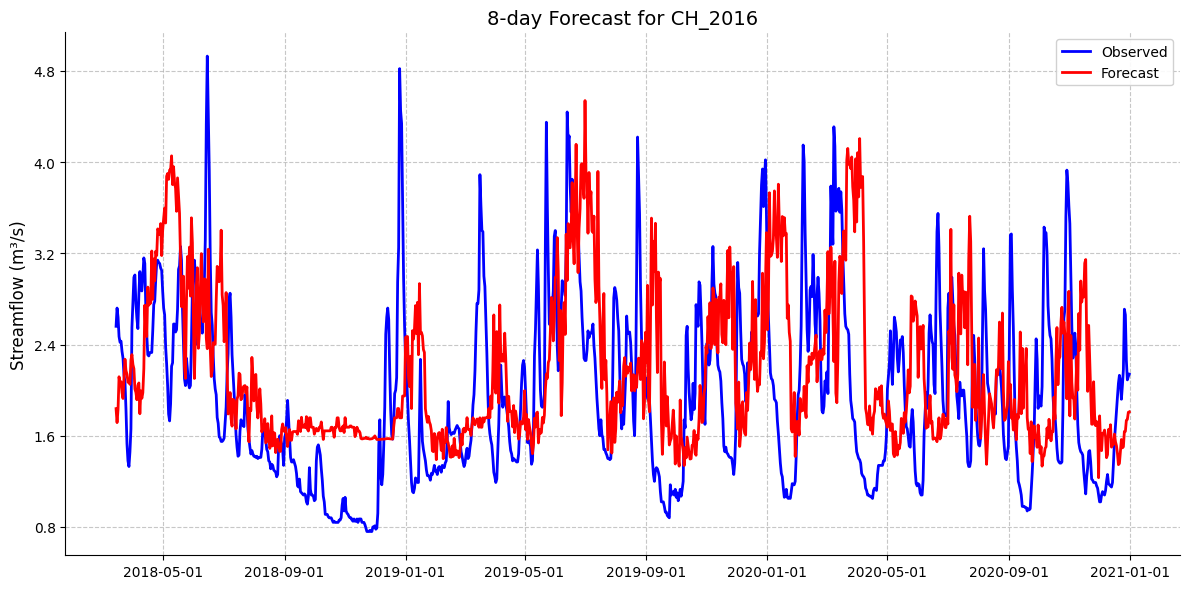

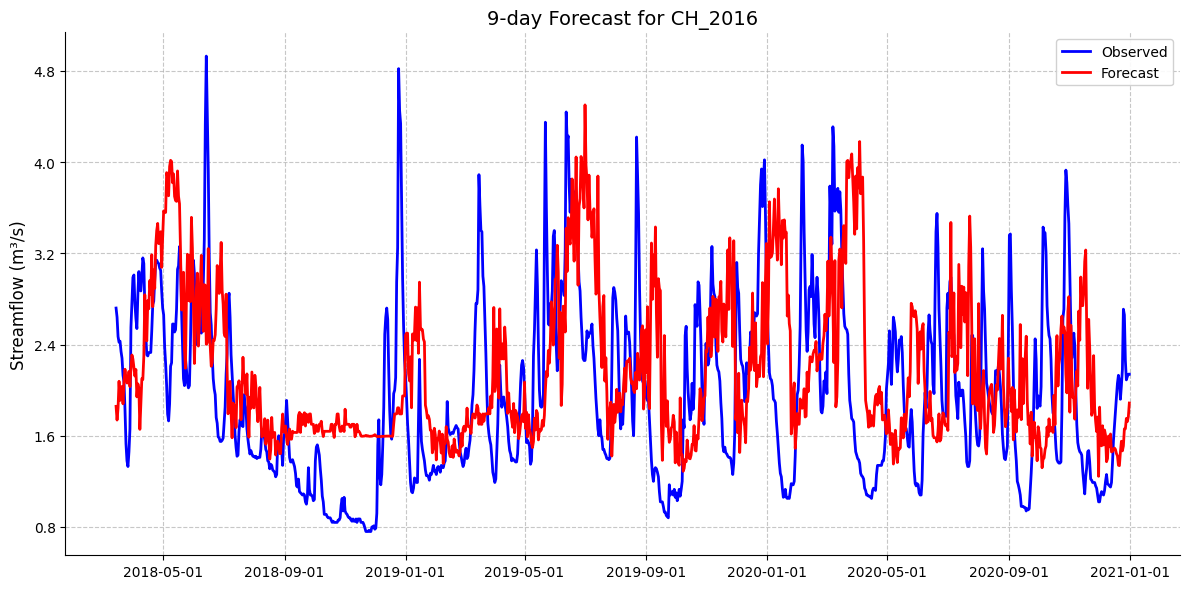

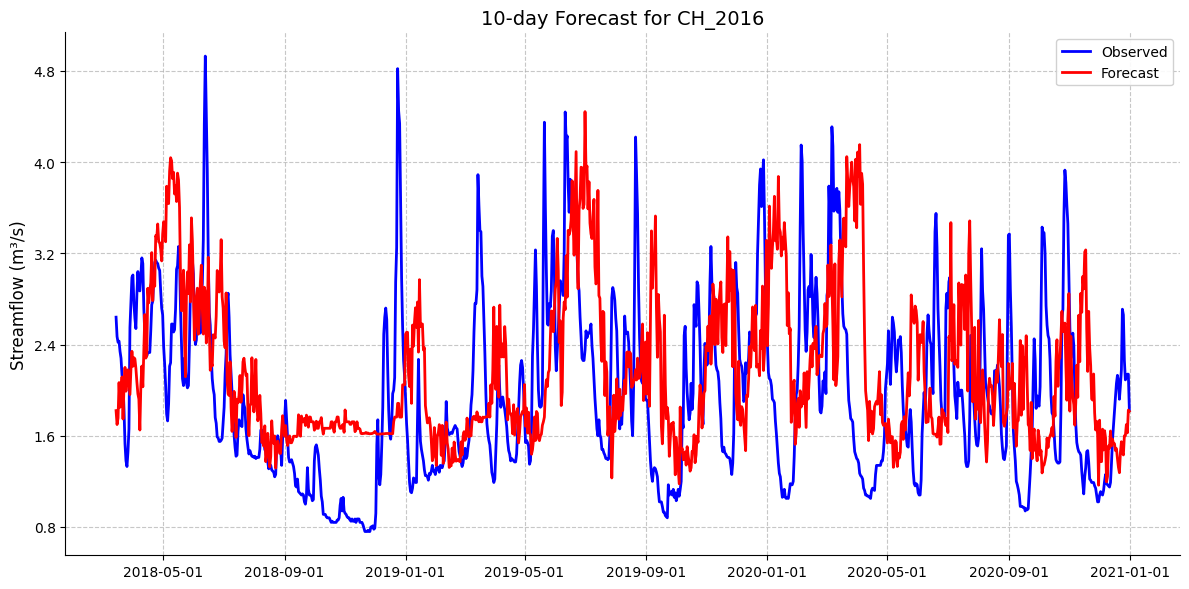

In [ ]:
evaluator.test_results = raw_results

# ['CH_2199' 'CH_2200' 'CH_2202' 'CH_2203' 'CH_2205' 'CH_2210' 'CH_2215'
#  'CH_2239' 'CH_2243' 'CH_2247' 'CL_1050002' 'CL_10514001' 'CL_10523002']

# Assuming you have an evaluator with test results already populated

fig, ax = evaluator.plot_rolling_forecast(
    horizon=1,
    group_identifier="CH_2016",
    datamodule=combined_dm,
    y_label="Streamflow (m³/s)",
    debug=True,
    line_style_forecast="-",
)

plt.show()


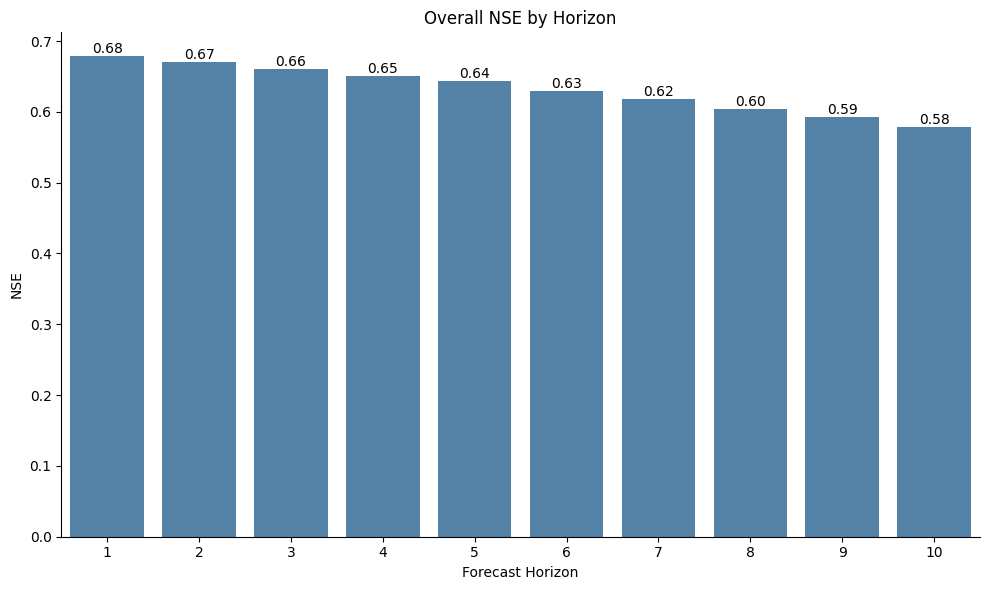

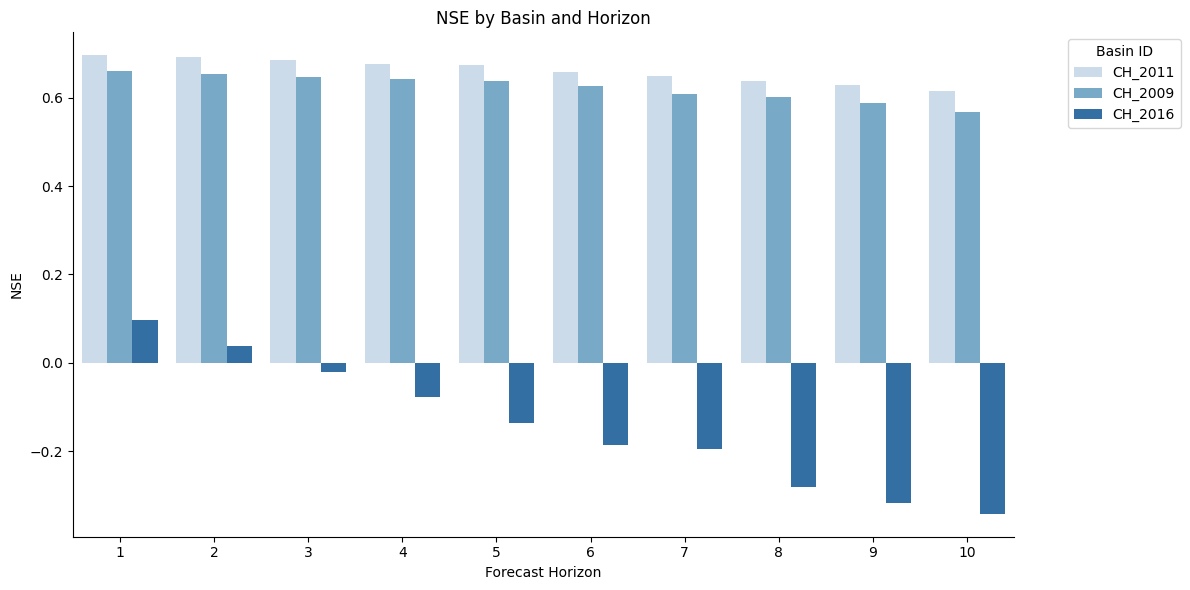

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_metric_summary(
    summary_df: pd.DataFrame, metric: str, per_basin: bool = False, figsize=(10, 6)
):
    plt.figure(figsize=figsize)

    if per_basin:
        df_plot = summary_df[metric].unstack(level=0)

        # Sort basins based on first horizon values
        first_horizon_values = df_plot.iloc[0]
        sorted_basins = first_horizon_values.sort_values(ascending=False).index
        df_plot = df_plot[sorted_basins]

        sns.barplot(
            data=df_plot.melt(ignore_index=False).reset_index(),
            x="horizon",
            y="value",
            hue="basin_id",
            palette="Blues",
        )
        plt.title(f"{metric} by Basin and Horizon")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Basin ID")

    else:
        ax = sns.barplot(x=summary_df.index, y=summary_df[metric], color="steelblue")
        plt.title(f"Overall {metric} by Horizon")

        for i, v in enumerate(summary_df[metric]):
            ax.text(i, v, f"{v:.2f}", ha="center", va="bottom")

    plt.xlabel("Forecast Horizon")
    plt.ylabel(metric)
    plt.tight_layout()
    sns.despine()
    plt.show()


# Usage example:
plot_metric_summary(overall_summary, "NSE")  # Plot overall NSE
plot_metric_summary(basin_summary, "NSE", per_basin=True, figsize=(12, 6))